In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
import pydicom

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [5]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
36962,00009727_048.png,Infiltration,48,9727,14,F,AP,2500,2048,0.168,0.168,NaN
98039,00025858_003.png,No Finding,3,25858,33,F,AP,3056,2544,0.139,0.139,NaN
27750,00007218_003.png,Atelectasis,3,7218,50,F,AP,2500,2048,0.168,0.168,NaN


In [6]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
4866,00025580_011.png,Atelectasis,11,25580,046Y,M,PA,2530,2991,0.143,0.143
936,00004893_022.png,Atelectasis,22,4893,029Y,M,AP,2500,2048,0.171,0.171
750,00003923_018.png,Infiltration,18,3923,028Y,M,AP,2500,2048,0.171,0.171


In [7]:
## EDA
# Todo 

thisdir = os.getcwd()

# r=root, d=directories, f = files
for r, d, f in os.walk(thisdir):
    for file in f:
            print(os.path.join(r, file))

/home/workspace/test5.dcm
/home/workspace/FDA_Submission_Template.md
/home/workspace/Build and train model.ipynb
/home/workspace/test4.dcm
/home/workspace/sample_labels.csv
/home/workspace/Inference.ipynb
/home/workspace/test6.dcm
/home/workspace/test2.dcm
/home/workspace/test3.dcm
/home/workspace/EDA.ipynb
/home/workspace/test1.dcm
/home/workspace/.ipynb_checkpoints/EDA-checkpoint.ipynb
/home/workspace/.ipynb_checkpoints/Inference-checkpoint.ipynb
/home/workspace/.ipynb_checkpoints/Build and train model-checkpoint.ipynb


# Explore 2D Imaging Properties

## Step 1: 
Read the first DICOM's pixel_array attribute into a dataframe using the pydicom.dcmread function

In [22]:
dcm = pydicom.dcmread("test1.dcm")
pixels0 = dcm.pixel_array

## Step 2: 
Visualize the image using plt.imshow

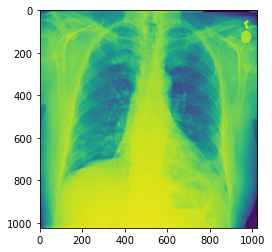

In [23]:
plt.imshow(pixels0)

## Step 3: 
plot a histogram of the image pixel intensity values

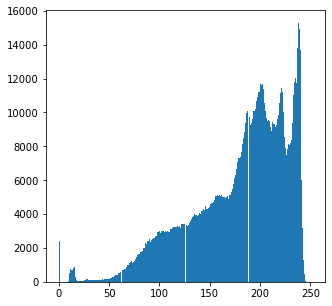

In [12]:
plt.figure(figsize=(5,5))
plt.hist(pixels0.ravel(), bins = 256)
plt.show()

Note the peak at zero, which are background pixels. This distribution makes it seem like the mean intensity is probably around 200, but let's find out for sure:

## Step 4: 
Find the mean and std dev intensity values of the image, and standerdize it

In [24]:
mean_intensity = np.mean(dcm.pixel_array)
mean_intensity

180.0586576461792

In [25]:
std_intensity = np.std(dcm.pixel_array)
std_intensity

47.89115072730743

In [26]:
new_img = dcm.pixel_array.copy()
new_img = (new_img - mean_intensity)/std_intensity

## Step 5: 
Re-plot a histogram of the normalized intensity values

(array([2.4090e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5000e+01,
        5.1900e+02, 7.5000e+02, 6.9700e+02, 7.2200e+02, 8.0100e+02,
        8.5400e+02, 2.9900e+02, 9.6000e+01, 5.6000e+01, 5.9000e+01,
        6.9000e+01, 5.9000e+01, 7.1000e+01, 7.1000e+01, 7.3000e+01,
        8.3000e+01, 8.5000e+01, 9.7000e+01, 1.6800e+02, 1.5600e+02,
        1.3300e+02, 1.2700e+02, 1.2300e+02, 1.1600e+02, 1.1500e+02,
        1.0900e+02, 1.0700e+02, 1.0700e+02, 1.0500e+02, 1.0200e+02,
        1.2400e+02, 1.1000e+02, 1.0500e+02, 1.1900e+02, 1.3700e+02,
        1.3400e+02, 1.4600e+02, 1.7300e+02, 1.5000e+02, 1.5000e+02,
        1.5600e+02, 1.9100e+02, 1.9500e+02, 2.4200e+02, 2.9500e+02,
        2.9200e+02, 3.4600e+02, 4.0000e+02, 3.9900e+02, 4.3000e+02,
        4.9500e+02, 5.3700e+02, 5.6300e+02, 0.0000e+00, 7.1100e+02,
        6.9100e+02, 7.3300e+02, 7.4600e+02, 8.5700e+02, 9.7200e+02,
        1.0050e+03, 1.0940e+03, 1.1660e+03, 1.22

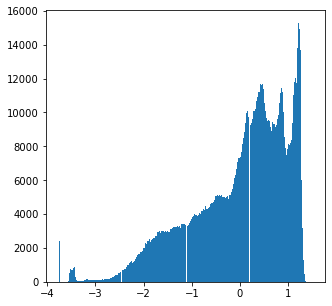

In [27]:
plt.figure(figsize=(5,5))
plt.hist(new_img.ravel(), bins = 256)

Notice how the histogram has the same shape, but now it's centered around 0. This is a key step in image pre-processing when we prepare imaging data for machine learning. 